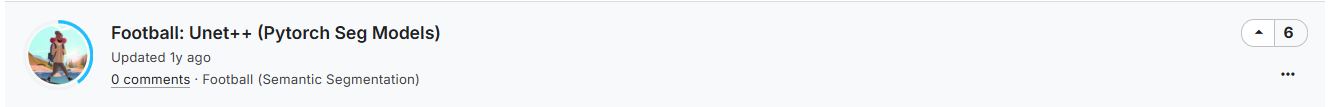

In [1]:
image_size=256
batch_size=8
epochs=50
lr=0.0003
encoder='resnet34'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

dir_path = r'D:\code_study\ML_CODE\dataSets\Segmentation\Football_Semantic_Segmentation\archive\images'
dir_path = dir_path.replace('\\','/')
file_paths = sorted(os.listdir(dir_path))

image_paths=[]
seg_paths=[]

for file in file_paths:
    if 'fuse' in file:
        seg_paths.append(file)
    elif 'save' in file:
        continue
    else:
        image_paths.append(file)
    
assert len(seg_paths)==len(image_paths)
print(f"Number of data pairs: {len(image_paths)}")

Number of data pairs: 100


In [4]:
import torch
import cv2
import albumentations as A

augs=A.Compose([
    A.RandomResizedCrop((image_size, image_size),
                        interpolation=cv2.INTER_LINEAR),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(0.2),
    A.VerticalFlip(0.2),
],is_check_shapes=False)

class FootballData(torch.utils.data.Dataset):
    def __init__(self, ip, sp, augs=None):
        self.ip=ip
        self.sp=sp
        self.augs=augs
    def __len__(self):
        return len(self.ip)
    def __getitem__(self, idx):
        image_path, seg_path = self.ip[idx], self.sp[idx]
        
        image=cv2.imread(os.path.join(dir_path,image_path))
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        seg=cv2.imread(os.path.join(dir_path,seg_path))
        seg=cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
        
        if self.augs!=None:
            data=self.augs(image=image,mask=seg)
            image,seg=data['image'],data['mask']
        
        image=torch.Tensor(np.transpose(image,(2,0,1))) / 255.0 
        seg=torch.Tensor(np.transpose(seg,(2,0,1))) / 255.0
        
        return image, seg
    
trainset=FootballData(image_paths,seg_paths,augs)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

print(f"{len(trainset)} images divided into {len(trainloader)} batches")

100 images divided into 13 batches


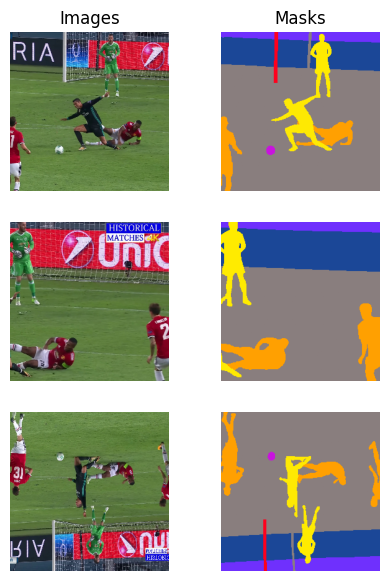

In [5]:
import matplotlib.pyplot as plt

idx=40
im1,s1=trainset[idx]
im2,s2=trainset[idx+1]
im3,s3=trainset[idx+2]


plt.figure(figsize=(5,7))
plt.subplot(3,2,1)
plt.imshow(im1.permute(1,2,0))
plt.axis('off')
plt.title('Images')

plt.subplot(3,2,2)
plt.imshow(s1.permute(1,2,0))
plt.axis('off')
plt.title('Masks')

plt.subplot(3,2,3)
plt.imshow(im2.permute(1,2,0))
plt.axis('off')

plt.subplot(3,2,4)
plt.imshow(s2.permute(1,2,0))
plt.axis('off')

plt.subplot(3,2,5)
plt.imshow(im3.permute(1,2,0))
plt.axis('off')

plt.subplot(3,2,6)
plt.imshow(s3.permute(1,2,0))
plt.axis('off')

plt.show()

In [6]:
!pip install -U segmentation-models-pytorch
!pip install torchsummary

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [7]:
import segmentation_models_pytorch as smp
from torch import nn
from torchsummary import summary

device='cuda' if torch.cuda.is_available() else 'cpu'

class SemSegModel(nn.Module):
    def __init__(self):
        super(SemSegModel,self).__init__()
        self.model = smp.UnetPlusPlus(encoder_name=encoder, encoder_weights='imagenet', in_channels=3, classes=3)
    def forward(self, img, seg=None):
        pred=self.model(img)
        if seg!=None:
            loss=nn.BCEWithLogitsLoss()(pred,seg)
            return loss, pred
        return pred

semseg=SemSegModel()
semseg.to(device);
summary(semseg, input_size=(3,image_size,image_size))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Leaper/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [05:32<00:00, 262kB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [8]:
from tqdm.auto import tqdm

def trainarc(model, dataloader, opt):
    model.train()
    train_loss=0.0 
    train_acc=0.0
    
    for img,seg in tqdm(dataloader):
        img,seg=img.to(device),seg.to(device)
        
        opt.zero_grad()
        loss,pred=model(img,seg)
        loss.backward()
        opt.step()
        
        acc=(torch.sum(seg-pred).item())/(batch_size*3*image_size*image_size)*100
        train_loss+=loss
        train_acc+=100-acc
    
    plt.subplot(1,3,1)
    plt.imshow(img[1].permute(1,2,0).detach().cpu().numpy())
    plt.axis('off')
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(pred[1].permute(1,2,0).detach().cpu().numpy())
    plt.axis('off')
    plt.title("Prediction")

    plt.subplot(1,3,3)
    plt.imshow(seg[1].permute(1,2,0).detach().cpu().numpy())
    plt.axis('off')
    plt.title("Truth")

    plt.show()
        
    return train_loss/len(dataloader), train_acc/len(dataloader)

  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.804321..2.5440316].


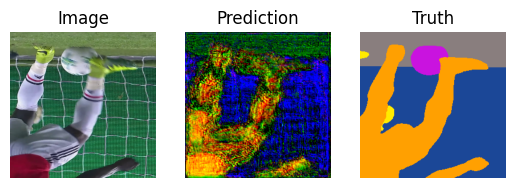

E: 1 - Loss: 0.680467426776886, Acc:47.11632361778846%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.119415..3.6616986].


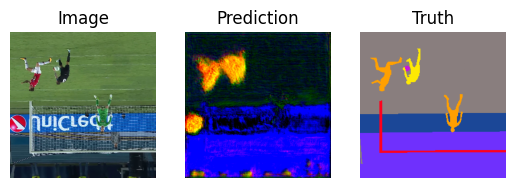

E: 2 - Loss: 0.6053999662399292, Acc:49.93702050967094%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.713813..5.6358347].


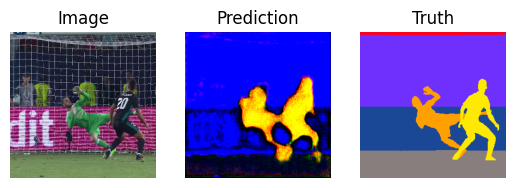

E: 3 - Loss: 0.577908456325531, Acc:52.36562276497865%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.093017..4.3822165].


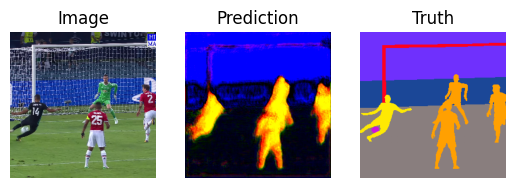

E: 4 - Loss: 0.5587436556816101, Acc:54.248064450728585%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.9745994..4.4459686].


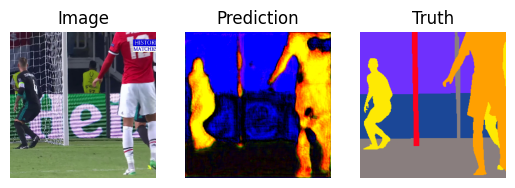

E: 5 - Loss: 0.5445263385772705, Acc:56.34013062868363%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.1456504..4.5457416].


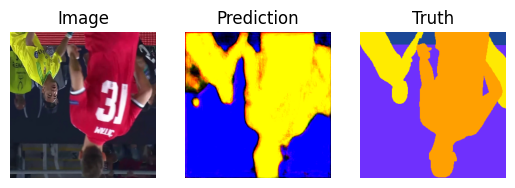

E: 6 - Loss: 0.5378274321556091, Acc:58.34703048070271%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.1728344..4.9804573].


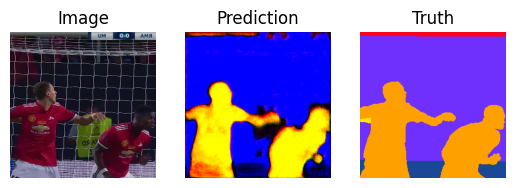

E: 7 - Loss: 0.5491735339164734, Acc:58.74884281402979%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.614107..10.216236].


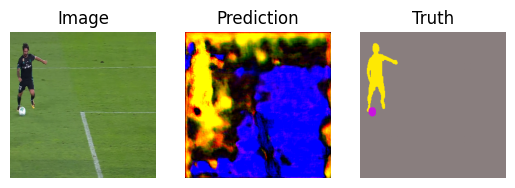

E: 8 - Loss: 0.5560771822929382, Acc:58.41532242603792%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7373338..4.2746825].


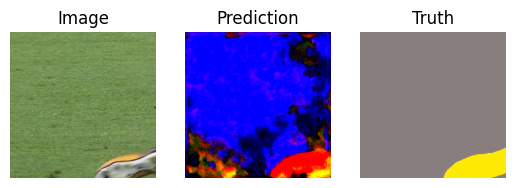

E: 9 - Loss: 0.5538145899772644, Acc:57.9223938477345%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.4488854..6.6600633].


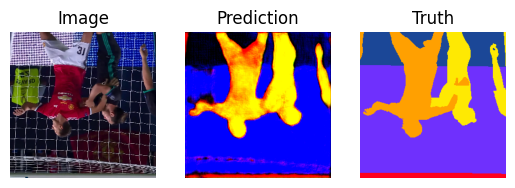

E: 10 - Loss: 0.5451284646987915, Acc:60.23658498739586%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.4834127..5.0034146].


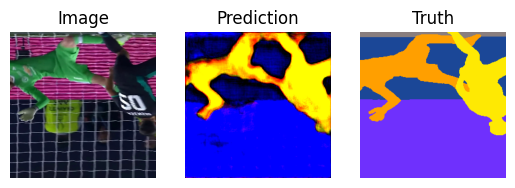

E: 11 - Loss: 0.5416930317878723, Acc:59.51181191664477%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.7763243..8.945512].


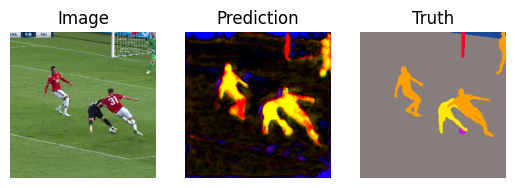

E: 12 - Loss: 0.546545684337616, Acc:60.6304990939605%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.801892..6.848123].


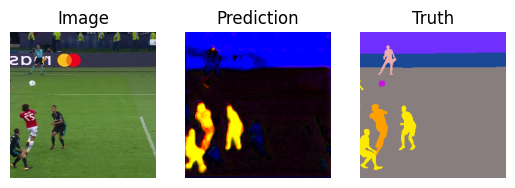

E: 13 - Loss: 0.528967022895813, Acc:60.98491748174031%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.052886..10.894747].


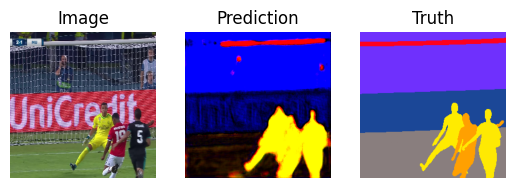

E: 14 - Loss: 0.5335860252380371, Acc:61.32368231431031%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.11208..7.6793447].


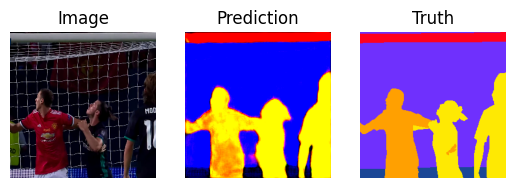

E: 15 - Loss: 0.5294128060340881, Acc:61.23813757529626%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.858965..7.3200145].


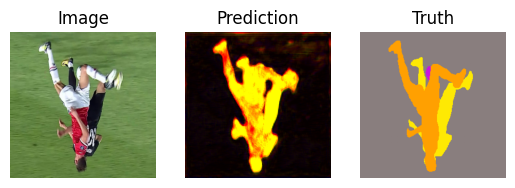

E: 16 - Loss: 0.5264894366264343, Acc:60.6503529426379%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.8467765..4.414357].


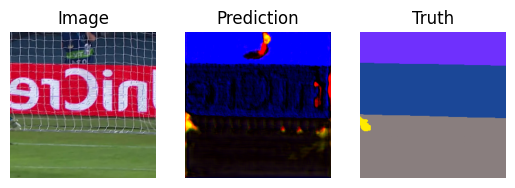

E: 17 - Loss: 0.5193251967430115, Acc:62.266515768491296%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.202572..9.331002].


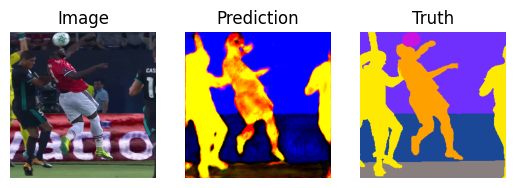

E: 18 - Loss: 0.5269091129302979, Acc:63.33418901150042%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.146567..8.950705].


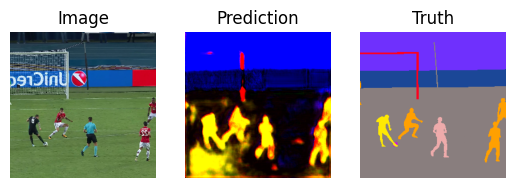

E: 19 - Loss: 0.5244461894035339, Acc:63.23245213581966%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.865704..5.555883].


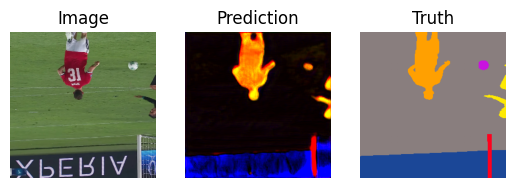

E: 20 - Loss: 0.5168901681900024, Acc:66.0860822750972%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.4976883..6.130323].


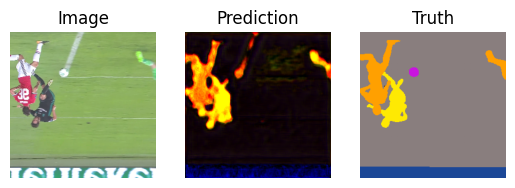

E: 21 - Loss: 0.5227750539779663, Acc:65.79596002896626%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.115758..6.062156].


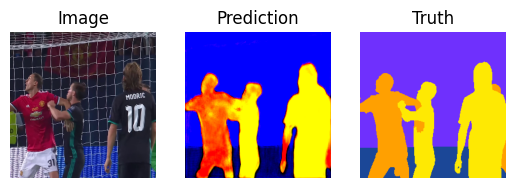

E: 22 - Loss: 0.5186312198638916, Acc:65.57547816863426%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.0729337..6.3209934].


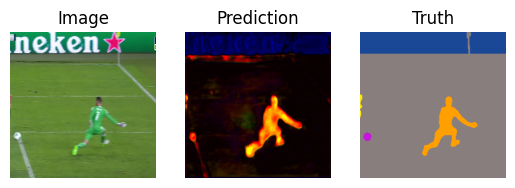

E: 23 - Loss: 0.5289239883422852, Acc:64.77699768848909%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.248195..8.235848].


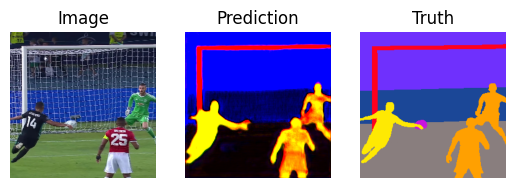

E: 24 - Loss: 0.5166929364204407, Acc:64.9831874248309%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.591608..9.5830555].


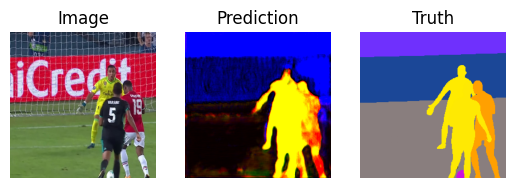

E: 25 - Loss: 0.533365786075592, Acc:64.39955723591339%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.064169..9.118878].


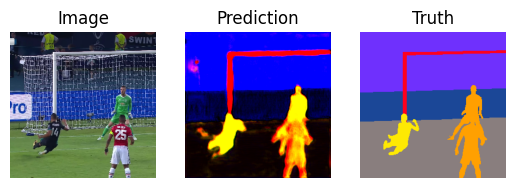

E: 26 - Loss: 0.5221714973449707, Acc:64.21456168859434%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.075571..9.703413].


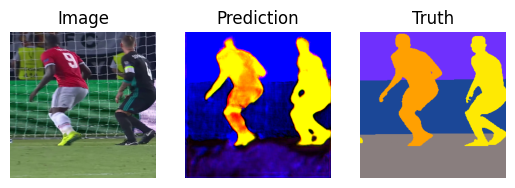

E: 27 - Loss: 0.5361348986625671, Acc:65.81321404530452%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.533904..7.6688824].


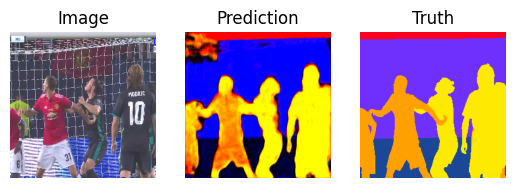

E: 28 - Loss: 0.5268341898918152, Acc:65.94214714490451%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.90852..8.99587].


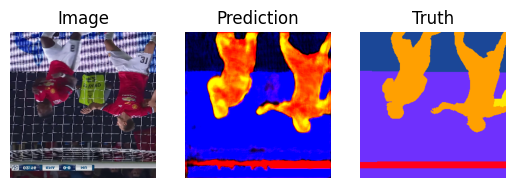

E: 29 - Loss: 0.5308459401130676, Acc:63.6643308859605%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.013478..11.422596].


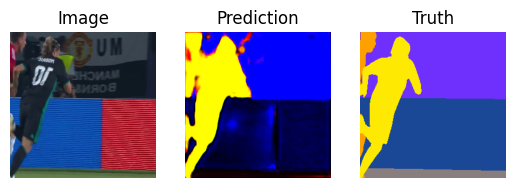

E: 30 - Loss: 0.5284811854362488, Acc:63.98844489684472%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.9137115..8.2354355].


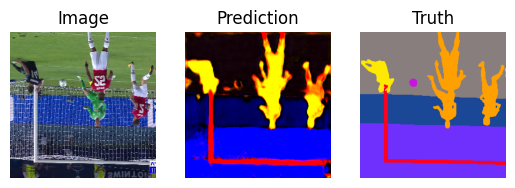

E: 31 - Loss: 0.5177135467529297, Acc:67.06080604822206%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.735179..8.286465].


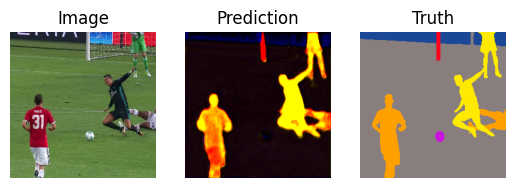

E: 32 - Loss: 0.5174592137336731, Acc:67.58830218743054%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.3032794..6.2246876].


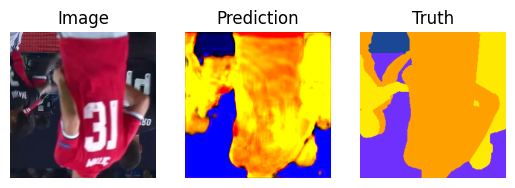

E: 33 - Loss: 0.5115298628807068, Acc:66.67385024902147%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.652438..7.789048].


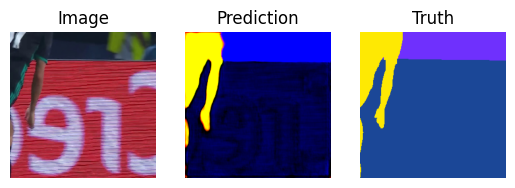

E: 34 - Loss: 0.5094020962715149, Acc:67.39532259794382%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.162383..11.519385].


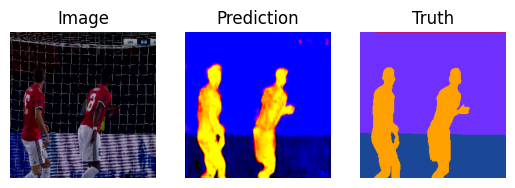

E: 35 - Loss: 0.5188413858413696, Acc:67.61869207406654%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.9224114..7.352852].


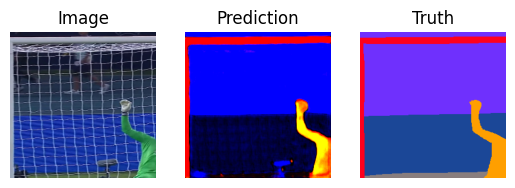

E: 36 - Loss: 0.5222912430763245, Acc:66.87786411016415%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.268681..4.720618].


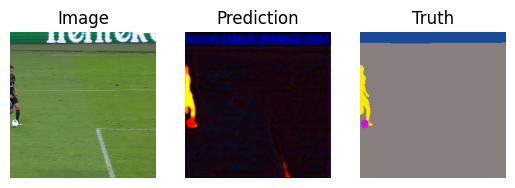

E: 37 - Loss: 0.5222204327583313, Acc:65.96959676498021%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.696472..7.6321054].


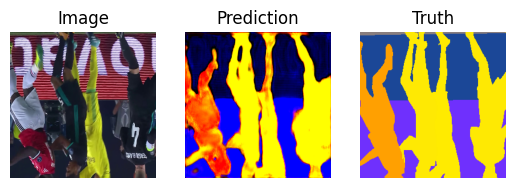

E: 38 - Loss: 0.5206223130226135, Acc:67.74746714494168%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.5084715..13.270797].


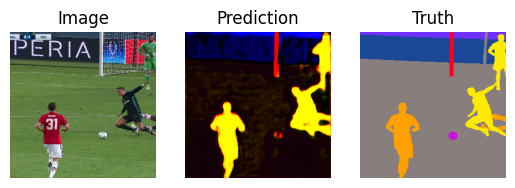

E: 39 - Loss: 0.5124387145042419, Acc:70.22921282511491%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.725783..13.510967].


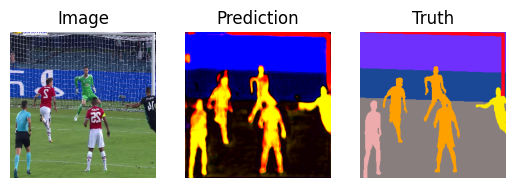

E: 40 - Loss: 0.5163881182670593, Acc:69.13710205982892%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.567177..6.706662].


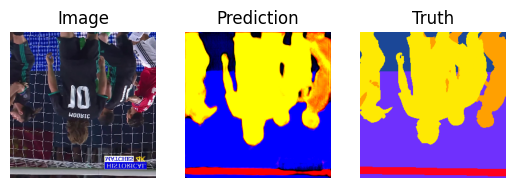

E: 41 - Loss: 0.5084230899810791, Acc:69.27430148308093%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.889694..1.4324163].


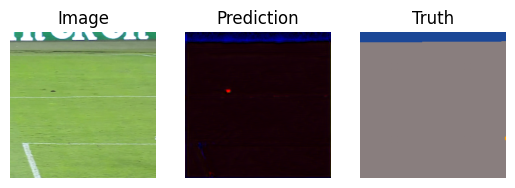

E: 42 - Loss: 0.5059192180633545, Acc:71.46215423559532%
Model Updated


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.6220455..15.47889].


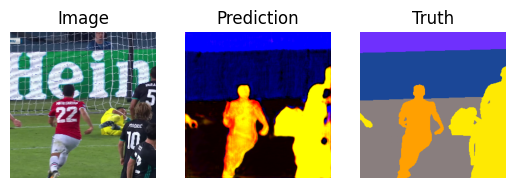

E: 43 - Loss: 0.5213216543197632, Acc:71.30557268093793%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.375219..6.8623953].


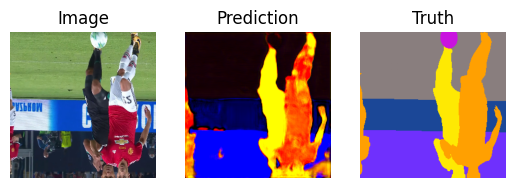

E: 44 - Loss: 0.5147172808647156, Acc:69.61649090815814%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.396309..7.328958].


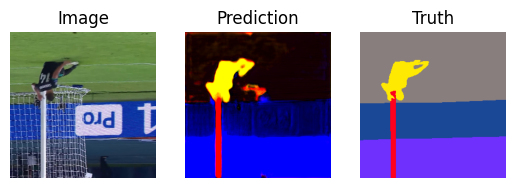

E: 45 - Loss: 0.5157743692398071, Acc:68.70494928115453%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3764036..3.5772498].


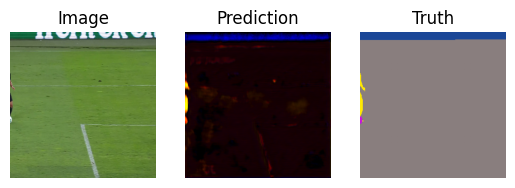

E: 46 - Loss: 0.5132275819778442, Acc:71.03006304838719%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.080112..9.009899].


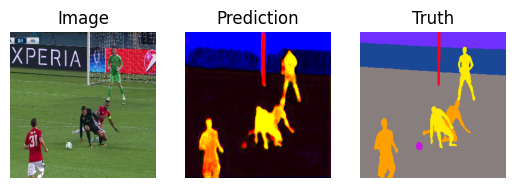

E: 47 - Loss: 0.5111306309700012, Acc:70.79316805570554%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.82065..10.72589].


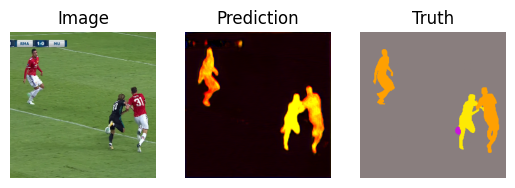

E: 48 - Loss: 0.5206066966056824, Acc:70.51435785415845%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.431776..9.192479].


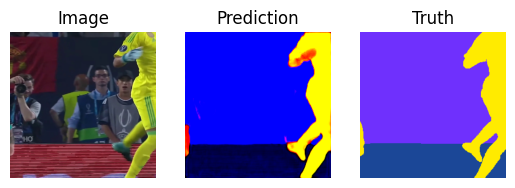

E: 49 - Loss: 0.5129292607307434, Acc:70.60063328498448%


  0%|          | 0/13 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14.494857..16.379263].


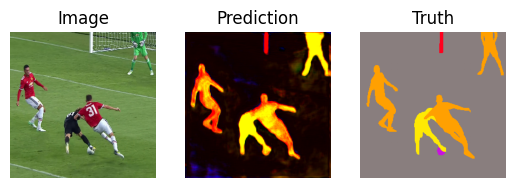

E: 50 - Loss: 0.5133653879165649, Acc:70.97805493917221%


In [10]:
opt=torch.optim.Adam(semseg.parameters(),lr=lr)

best_loss=np.inf
for i in range(epochs):
    loss, acc = trainarc(semseg, trainloader, opt)
    
    print(f"E: {i+1} - Loss: {loss}, Acc:{acc}%")
    
    if loss<best_loss:
        torch.save(semseg.state_dict(),'/kaggle/working/seg.pt')
        print("Model Updated")
        best_loss=loss